## Imports

In [3]:
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify

from sympy import init_printing
init_printing(use_latex=True)
import matplotlib.pyplot as plt

import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [17]:
def solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu):
    for n in range(nt):
        for k in range(nx-1): un[k]=u[k]
        for i in range(1,nx-1):
            u[i]=un[i]+nu*dt*(un[i-1]+un[i+1]-2*un[i])/(dx**2)-un[i]*dt*(un[i]-un[i-1])/dx
        
    return 0

## Numba accelerator

In [20]:
@njit(fastmath=True)
def solve_1d_burger_numba(u, un, nt, nx, dt, dx, nu):
    for n in range(nt):
        for k in range(nx-1): un[k]=u[k]
        for i in range(1,nx-1):
            u[i]=un[i]+nu*dt*(un[i-1]+un[i+1]-2*un[i])/(dx**2)-un[i]*dt*(un[i]-un[i-1])/dx
        
    return 0

## Pyccel accelerator

In [21]:
@types('float[:]','float[:]','int','int','float','float','float')
def solve_1d_burger_pyccel(u, un, nt, nx, dt, dx, nu):
    for n in range(nt):
        for k in range(nx-1): un[k]=u[k]
        for i in range(1,nx-1):
            u[i]=un[i]+nu*dt*(un[i-1]+un[i+1]-2*un[i])/(dx**2)-un[i]*dt*(un[i]-un[i-1])/dx
        
    return 0

## Inputs

In [10]:
#sympy computation
x, nu, t = sp.symbols('x nu t')
phi = (sp.exp(-(x - 4 * t)**2 / (4 * nu * (t + 1))) +
       sp.exp(-(x - 4 * t - 2 * sp.pi)**2 / (4 * nu * (t + 1))))

phiprime = phi.diff(x)
u = -2 * nu * (phiprime / phi) + 4
ufunc = lambdify((t, x, nu), u)

In [11]:
###variable declarations
nx = 201
nt = 100
dx = 2 * np.pi / (nx - 1)
nu = .07
dt = dx * nu

x = np.linspace(0, 2 * np.pi, nx)
un = np.empty(nx)
t = 0

## Plot initial condition

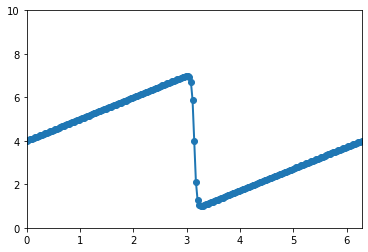

In [22]:
u = np.asarray([ufunc(t, x0, nu) for x0 in x])
plt.figure()
plt.plot(x, u, marker='o', lw=2)
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10]);

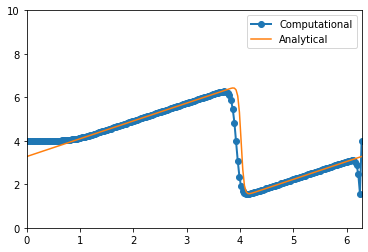

In [23]:
solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu)

# Analytical solution
u_analytical = np.asarray([ufunc(nt * dt, xi, nu) for xi in x])


#Plotting data
plt.figure()
plt.plot(x,u, marker='o', lw=2, label='Computational')
plt.plot(x, u_analytical, label='Analytical')
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 10])
plt.legend();

## Call Funtions

### Pure function

In [24]:
%timeit solve_1d_burger_pure(u, un, nt, nx, dt, dx, nu)

106 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Function with numba accelerator

In [25]:
%timeit solve_1d_burger_numba(u, un, nt, nx, dt, dx, nu)

30 µs ± 5.58 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with pyccel accelerator

In [26]:
solve_1d_burger_f90 = epyccel(solve_1d_burger_pyccel)
%timeit solve_1d_burger_f90(u, un, nt, nx, dt, dx, nu)

143 µs ± 92.6 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
